This is a jupyter notebook to get the graphs from geo maps.

In [270]:
import random
import os
import numpy as np
import networkx as nx
import geopandas as gpd
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt

from matplotlib.collections import PatchCollection


# Load the box module from shapely to create box objects
from shapely.geometry import box, Point, Polygon, MultiPoint, shape, LineString
from shapely.ops import triangulate
from shapely.affinity import translate

from earthpy import clip as cl
import pickle #to save the resulting graphs

# to display images inline
get_ipython().magic(u'matplotlib inline')
matplotlib.use('Agg')# not sure what I used it for


# RELATIVE NEIGHBORHOOD GRAPH

This notebook demonstrated how RNG graphs can be calculated from  OSM data in the form of shapefiles.
Recent OSM data can be downloded from the project website, here we use a French region called Lorraine.

#### Pre-processing:

We processed data in QGIS to merge the buildings which touch, and to extract  certain separate categories from the buildings.

#### Categories
A pre-selected set of objects  is defined. The nodes of our graphs are formed by these objects,each category is cooded as a unique integer. Some of categories are missing from OSM data, but we keep the codes to be consistent.

aerodroms:    0

houses:       1

public build: 2 

railway stat: 3

sport build:  4

arcs, towers: 5

churches:     6

castles:      7

forts:        8

monuments:    9

cemetries:   10

sport build: 11

roads:       12

water:       13

railroads:   14
 


In [271]:
# define the region folder - folder where OSM data are unpacked
global_path = "./lorraine"

Load all shapefiles as geopandas dataframes. We also convert the data to Lambert 93 on the way.

## ROADS

In [272]:
# load all the shapely files related to ROADS
fp_road = global_path + "/gis_osm_roads_free_1.shp"
all_roads = gpd.read_file(fp_road)
all_roads = all_roads.to_crs("EPSG:2154") 

In [273]:
all_roads.head() # small demo of the roads and the info we have

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry
0,2284506,5131,motorway_link,None,A 31,F,70,0,F,F,"LINESTRING (926317.999 6848103.926, 926303.576..."
1,2306356,5131,motorway_link,None,A 31,F,110,0,F,F,"LINESTRING (925999.230 6847969.946, 926002.566..."
2,2371422,5131,motorway_link,None,None,F,0,0,F,F,"LINESTRING (911516.762 6818357.130, 911510.086..."
3,2371423,5141,service,None,None,F,0,0,F,F,"LINESTRING (911470.001 6818072.927, 911471.198..."
4,2371424,5141,service,None,None,F,0,0,F,F,"LINESTRING (911445.587 6817975.063, 911440.070..."


Data type - geographical projection of he data used.

## Houses

In [274]:
# Load all the data from the BUILDINGS caegory
fp_bati = global_path + "/buildings_merged.shp"
# Read file using gpd.read_file()
all_buildings = gpd.read_file(fp_bati)
all_buildings = all_buildings.to_crs("EPSG:2154") 


## Churches

In [275]:
#places of worship
churches = global_path +  "/gis_osm_pofw_free_1.shp"
churches = gpd.read_file(churches)
churches=churches.to_crs("EPSG:2154") 

## Towers, castles, forts, monuments

In [277]:
fp_poi = global_path + "/gis_osm_pois_free_1.shp" 
# Read file using gpd.read_file()
poi = gpd.read_file(fp_poi)
poi=poi.to_crs("EPSG:2154") 
poi.fclass.unique()
towers = poi.loc[poi['fclass'] == 'tower']
castels = poi.loc[poi['fclass'] == 'castle']
forts = poi.loc[poi['fclass']=='fort']
monuments = poi.loc[poi['fclass']=='monument']

In [278]:
print("statisics over all POI objects. There %d churches, %d towers, %d monuments, %d forts, %d castles and %d ordinary buildings" 
      %(len(churches),len(towers),len(monuments), len(forts), len(castels), len(all_buildings)))

statisics over all POI objects. There 308 churches, 58 towers, 129 monuments, 5 forts, 88 castles and 880615 ordinary buildings


## WATER 

In [279]:
fp_water =  global_path + "/gis_osm_waterways_free_1.shp"
all_water = gpd.read_file(fp_water)
all_water = all_water.to_crs("EPSG:2154")

## SPORT TERRITORIES

In [280]:
fp_sport = global_path +  "/gis_osm_pois_free_1.shp"
data_sport = gpd.read_file(fp_sport)
data_sport=data_sport.to_crs("EPSG:2154") 
data_sport = data_sport.loc[data_sport['fclass'] == 'stadium']

## CEMETRIES

In [281]:
fp_cemetries = global_path +  "/gis_osm_pois_a_free_1.shp"
data_cemetries = gpd.read_file(fp_cemetries)
data_cemetries=data_cemetries.to_crs("EPSG:2154") 
#pick the graveyards
data_cemetries =  data_cemetries.loc[data_cemetries['fclass'] =='graveyard']

## RAILROADS

In [282]:
#railroads
fp_rail = global_path + "/gis_osm_railways_free_1.shp"
data_rail  = gpd.read_file(fp_rail)
data_rail = data_rail.to_crs("EPSG:2154") 

In [285]:
print("statisics over all line objects. There %d road segments, %d water segements, %d railroad segments" 
      %(len(all_roads),len(all_water),len(data_rail)))

statisics over all line objects. There 305429 road segments, 17094 water segements, 9002 railroad segments


## BOUNDING BOXES FROM THE IMAGES

We use the pre-save bounding boxes, just change the paths to the right one. The bounding box just limits the zone to create different graphs.

In [286]:
image_polygons = gpd.read_file('image_polygons_57.shp') # image polygons for POI in Moselle region

In [50]:
image_polygons

,ID,PREC_PLANI,PREC_ALTI,ORIGIN_BAT,NATURE,HAUTEUR,Z_MIN,Z_MAX,geo_ID,geometry
0,BATIMENT0000000053807577,1.5,1.0,Autre,Gare,9,226.2,226.3,6,"POLYGON ((933427.610 6847868.515, 933427.610 6..."
1,BATIMENT0000000053740974,1.5,1.0,Autre,Gare,6,222.8,225.2,1,"POLYGON ((888816.597 6930223.834, 888816.597 6..."
2,BATIMENT0000000053767449,1.5,1.0,Autre,Gare,12,221.6,227.1,2,"POLYGON ((910011.111 6876467.135, 910011.111 6..."
3,BATIMENT0000000053771142,1.5,1.0,Autre,Gare,11,186.4,193.0,3,"POLYGON ((923515.477 6870907.788, 923515.477 6..."
4,BATIMENT0000000053777052,1.5,1.0,Autre,Gare,7,189.8,192.7,4,"POLYGON ((925265.595 6864707.886, 925265.595 6..."
...,...,...,...,...,...,...,...,...,...,...
2120,BATIMENT0000000053875433,10.0,9999.0,Autre,Monument,0,-99.0,-99.0,2120,"POLYGON ((978947.823 6826816.155, 978947.823 6..."
2121,BATIMENT0000000053880944,10.0,9999.0,Autre,Monument,0,-99.0,-99.0,2121,"POLYGON ((976491.749 6822570.362, 976491.749 6..."
2122,BATIMENT0000000053847778,10.0,9999.0,Autre,Monument,0,-99.0,-99.0,2122,"POLYGON ((963230.770 6838787.953, 963230.770 6..."
2123,BATIMENT0000000053876671,10.0,9999.0,Autre,Chapelle,0,-99.0,-99.0,2123,"POLYGON ((962822.350 6826286.650, 962822.350 6..."


## graph creation routine
Below are the functions defined for each step of  RNG graph creation procedure.

In [287]:
# parameters of the nodes
def calculate_eccentricity(geometry):
    ''' function calculates eccentricity measure (w/l of min envelop rectangle) '''
    envelop_rect = geometry.minimum_rotated_rectangle
    minx, miny, maxx, maxy = envelop_rect.bounds
    width = maxx - minx
    height = maxy - miny
    if height ==0 or width ==0:
        return 0
    if width < height:
        return  width/height
    else:
        return height/width
        
def calculate_perimeter(geometry):
    ''' function calculates the perimeter of the shapely geometry '''
    return geometry.length
# unit tests
# calculate_perimeter(buildings3.geometry[1])

In [288]:
def get_node_attributes(shapely_geometry, poly_bound, nature, within_poly = True):
    """ function returns attributes of road/house node:
    nature, normed_lenght and eccentricity """
    attributes = {}
    obj_type = nature
    if within_poly:
        obj_length = calculate_perimeter(shapely_geometry)
        frame_perimeter = poly_bound.length
        obj_normed_length = obj_length/frame_perimeter 
        obj_points = calculate_eccentricity(shapely_geometry)
    else:
        obj_normed_length = 0
        obj_points = 0
    attributes = {'nature': obj_type, 'normed_length':obj_normed_length, 
                 'eccentricity':obj_points}
    return attributes

In [289]:
def calculate_distance(obj1, obj2):
    ''' this fucntion calculates the minimum distance between the objects:
    if an object is a polygon, its center is considered as a central point
    if an object is a line, the distance is the lenght of the normal from another object,
    if both objects are lines, the distance is 0'''
    d = None
    if obj1.type == 'Polygon' and obj2.type == 'Polygon':
        #print("polyg polyg")
        proj_dist = obj1.centroid.distance(obj2.centroid) #euclidean distance
        d = proj_dist
    elif obj1.type == 'LineString' and obj2.type == 'Polygon':
        #print("linestr polyg")
        proj_dist= obj2.centroid.distance(obj1) 
#         print(proj_dist)
#         print(obj1.project(obj2.centroid))
        d = proj_dist
    elif obj2.type=='LineString' and obj1.type == 'Polygon':
        #print(" polyg linestr")
        proj_dist= obj1.centroid.distance(obj2)     
        d = proj_dist
    elif obj1.type == 'LineString' and  obj2.type=='LineString':
        #print(" linestr linestr")
        if obj1.intersects( obj2):
            d = 0
        else:
            d = None
    elif obj1.type == 'shapely.geometry.LineString' and  obj2.type=='shapely.geometry.LineString':
        #print(" linestr linestr")
        if obj1.intersects( obj2):
            d = 0
        else:
            d = None    
    else:
        print(" unkn unkn")
        try:
            print(type(obj1),type(obj2))
            d = obj2.distance(obj1.centroid)
        except:
            print('Distance calc didnt work')
            d = None
    #print(f"d is {d} for objects {type(obj1)} {type(obj2)}")
    return d

In [290]:
def determine_if_connected_rng(geodf, idx1, idx2, distance_matrix):
    ''' check if the nodes are connected in the graph (the algorithm specified in
    here https://en.wikipedia.org/wiki/Relative_neighborhood_graph is  used, it is not optimized
    for big graphs (polynomial time version is implemented))'''
    connected = False
    dist = distance_matrix[idx1][idx2]
    dmax =[]
    N = distance_matrix.shape[0]
    if N>2:
        for i in range(N):
            if i!=idx1 and i!=idx2:
                dmax.append(max(distance_matrix[idx1][i], distance_matrix[idx2][i]))   
        connected = dist <= min(dmax)
    else:
        connected = True
    return connected,dist
        

In [291]:
def calculate_distance_matrix(geodf):
    ''' returns distance matrix between all the nodes'''
    dist_matrix = np.zeros((len(geodf),len(geodf)))
    for shp1 in range(0, len(geodf)):
         for shp2 in range(0, len(geodf)):
                dist_matrix[shp1][shp2] = geodf.centroid[shp1].distance(geodf.centroid[shp2])
        
    np.fill_diagonal(dist_matrix, float('inf'))
    return dist_matrix

In [292]:
def calculate_centroids(geodf):
    ''' calculates geometrical centers of geometries'''
    geodf = geodf.assign(centroid="")
    for i in range(len(geodf)):
        if type(geodf.loc[i, ('geometry')]) == 'Point':
            geodf.loc[i, ('centroid')] = geodf.loc[i, ('geometry')]
        else:
            geodf.centroid[i] = geodf.loc[i, ('geometry')].centroid
            
    return geodf

In [293]:
def create_rng_graph(gp_frame, poly = None):
    ''' function takes the pandas frame and creates the graph, where the nodes are rivers and roads,
    and buildings, and sportive objects etc.
    Nodes have the following attributes: 
    a) type of object (road/water/house/church etc)
    b) eccentricity
    c) length (divided by HxW of the polygon to scale)
    Edges have attributes based on the normalized distance between the points:
    they are calculated by the algorithm proposed 
    here: 
    https://en.wikipedia.org/wiki/Relative_neighborhood_graph
    '''
    pos = {} #dictionary for node coord
    net = nx.Graph() # empty graph   
    attr = {}
    dist_matrix = calculate_distance_matrix(gp_frame) 
    for shp1 in range(0, len(gp_frame)-1): # for each object
        # the geometry property here may be specific to my shapefile
        object1 = gp_frame['geometry'].iloc[shp1] #get the line
        pos[shp1] = [gp_frame['geometry'].iloc[shp1].centroid.x,  gp_frame['geometry'].iloc[shp1].centroid.y]
        # get all line attributes
        attributes = get_node_attributes(object1, poly, gp_frame['nature'].iloc[shp1],gp_frame['withinPoly'].iloc[shp1])
        net.add_node(shp1) # add node
        attr[shp1]= attributes # nested dict
        for shp2 in range(shp1+1, len(gp_frame)):
            object2 = gp_frame['geometry'].iloc[shp2] #get the second object
            connected, dist = determine_if_connected_rng(gp_frame, shp1, shp2, dist_matrix)
            if connected: # if intersects               
                net.add_edge(shp1, shp2, distance = dist) # edge with an attribute

        # add the last element - coz first loop is not for all values, and last node needs attributes
        attributes = get_node_attributes(object2, poly, gp_frame['nature'].iloc[shp2],gp_frame['withinPoly'].iloc[shp2])
        attr[len(gp_frame)-1]= attributes # nested dict
        net.add_node(shp2) # add node 
        nx.set_node_attributes(net, attr)

        pos[shp2] = [gp_frame['geometry'].iloc[shp2].centroid.x, gp_frame['geometry'].iloc[shp2].centroid.y]

    return net, pos

In [294]:
from shapely.ops import split
def divide_road_into_segments(final_data, nature, geoobject, inside_polygon =1,  max_line_seg_len = 10 ):
    ''' this function divides the road into a set of segments '''
    number_of_segments = int(geoobject.length// max_line_seg_len)
   
    if number_of_segments>1:
        for i in range(1, number_of_segments):
            #cutting_point=geoobject.interpolate(i/number_of_segments)
            #dist= geoobject.project(cutting_point)
            segment = cut(geoobject, max_line_seg_len)
            segment, geoobject  = segment[0], segment[1]
            final_data.append([nature, 1, segment])
    else:
        final_data.append([nature, 1,  geoobject])
    return final_data

def cut(line, distance):
    # Cuts a line in two at a distance from its starting point
    if distance <= 0.0 or distance >= line.length:
        return [LineString(line)]
    coords = list(line.coords)
    for i, p in enumerate(coords):
        pd = line.project(Point(p))
        if pd == distance:
            return [
                LineString(coords[:i+1]),
                LineString(coords[i:])]
        if pd > distance:
            cp = line.interpolate(distance)
            return [
                LineString(coords[:i] + [(cp.x, cp.y)]),
                LineString([(cp.x, cp.y)] + coords[i:])]               
    
    

In [295]:
## version with splitting!!!!!
def clean_and_append(final_data, data_segment, nature, polygon_bbox,  max_line_seg_len):
    ''' function copies data from a data frame to a new data list of a following structure:
    nature
    within the image (bool) if the object is entirely inside the polygon or not
    geometry
    returns list of lists with objects like  [[nat, within, geom], [], []...]  '''
    # if it is line object
    if data_segment.empty == True:
        pass     
    else:
        # check if object is completely within the polygon
        for index, row in data_segment.iterrows(): # for each element           
            if row['geometry'].geom_type == 'MultiPolygon' or row['geometry'].geom_type == 'MultiLineString':
                for single_obj in row['geometry']:
                        if nature in [12,13,14]:
                            final_data = divide_road_into_segments(final_data, nature, single_obj, 1, 15)
                        else:
                            final_data.append([nature, 1, single_obj]) 
                print('a multistring detected and transformed') 
            elif row['geometry'].is_empty or row['geometry']==[]:
                pass
            else:
                if nature in [12,13,14]:
                    final_data = divide_road_into_segments(final_data, nature, row['geometry'], 1,  max_line_seg_len)
                else:
                    final_data.append([nature, 1, row['geometry']]) # polygons are classified depending on their status always within 

    return final_data

In [296]:
def clip_data(pd_obj, pd_polyg):
    try:
        sg = cl.clip_shp(pd_obj, pd_polyg) #all_roads[all_roads.geometry.intersects(polygon_bbox)] #extract segments of roads
    except:
        sg = pd.DataFrame()
    return sg
    

In [298]:
#some variables to define
max_line_seg_len = 10 # if the roads should be cut, define this one, if not -> put a big value
name = './range_graphs/' #folder name where the graphs will be save as pickle files

for i in range(1,2) : # len(image_polygons)
    # randomly shift the polygon box
    polygon_bbox = image_polygons.iloc[i-1:i]
    data = []
    # lines
    sg_roads = clip_data(all_roads, polygon_bbox) #extract segments of roads
    data = clean_and_append(data, sg_roads, 12, polygon_bbox, max_line_seg_len)
    sg_water = clip_data(all_water, polygon_bbox) #extract segments of water
    data = clean_and_append(data, sg_water, 13, polygon_bbox, max_line_seg_len)
    sg_data_rail = clip_data(data_rail, polygon_bbox)
    data = clean_and_append(data, sg_data_rail, 14, polygon_bbox,max_line_seg_len)
    # objects
    sg_houses = clip_data(all_buildings, polygon_bbox) #extract segments of buildings
    data = clean_and_append(data, sg_houses, 1, polygon_bbox,max_line_seg_len)
    sg_towers = clip_data(towers, polygon_bbox)#towers[towers.intersects(polygon_bbox)]
    data = clean_and_append(data, sg_towers, 5, polygon_bbox, max_line_seg_len)
    sg_churches = clip_data(churches, polygon_bbox) # churches[churches.intersects(polygon_bbox)]
    data = clean_and_append(data, sg_churches, 6, polygon_bbox, max_line_seg_len)
    sg_castels = clip_data(castels, polygon_bbox)#castels[castels.intersects(polygon_bbox)]
    data = clean_and_append(data, sg_castels, 7, polygon_bbox, max_line_seg_len)
    sg_forts = clip_data(forts, polygon_bbox)#forts[forts.intersects(polygon_bbox)]
    data = clean_and_append(data, sg_forts, 8, polygon_bbox,max_line_seg_len)
    sg_monuments = clip_data(monuments, polygon_bbox)#monuments[monuments.intersects(polygon_bbox)]
    data = clean_and_append(data, sg_monuments, 9, polygon_bbox,max_line_seg_len)
    sg_data_cemetries = clip_data(data_cemetries, polygon_bbox)#data_cemetries[data_cemetries.geometry.intersects(polygon_bbox)]
    data = clean_and_append(data, sg_data_cemetries, 10, polygon_bbox,max_line_seg_len)
    sg_sport = clip_data(data_sport, polygon_bbox)#data_sport[data_sport.geometry.intersects(polygon_bbox)] #extract segments of sport  things
    data = clean_and_append(data, sg_sport, 11, polygon_bbox,max_line_seg_len)
    combined_pd = pd.DataFrame(data, columns = ['nature','withinPoly', 'geometry']) 
    sg_houses_rem =  pd.concat([sg_sport, sg_towers,sg_churches, sg_data_cemetries, sg_castels,sg_forts,sg_monuments],ignore_index=True)
    combined_pd = calculate_centroids(combined_pd)
    print(name +'graph_main'+ str(i).zfill(5) +'.pickle')
    print(len(combined_pd))
    if combined_pd.empty:
        G = nx.empty_graph()
    else:
        G, pos = create_rng_graph(gp_frame=combined_pd, poly=polygon_bbox)
    nx.write_gpickle(G, name + str(i).zfill(5) +'_graph' +'.pickle', protocol=4)
    with open(name + str(i).zfill(5)  +'_position.pickle', 'wb') as handle:
        pickle.dump(pos, handle)

./range_graphs/graph_main00001.pickle
37


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Resulting graphs demo

In [299]:
  combined_pd # all objetcs in a graph (nodes)

,nature,withinPoly,geometry,centroid
0,12,1,LINESTRING (972374.9738118855 6858925.28828167...,POINT (972379.4112198038 6858922.984065767)
1,12,1,LINESTRING (972383.8486277224 6858920.67984985...,POINT (972388.2860356409 6858918.375633946)
2,12,1,LINESTRING (972392.7234435594 6858916.07141803...,POINT (972396.9804801763 6858913.464551323)
3,12,1,LINESTRING (972401.1335218324 6858910.68318813...,POINT (972405.2715736432 6858907.876672994)
4,12,1,LINESTRING (972409.4096254538 6858905.07015785...,POINT (972413.5476772644 6858902.263642721)
5,12,1,LINESTRING (972417.6857290751 6858899.45712758...,POINT (972421.8237808857 6858896.650612447)
6,12,1,LINESTRING (972425.9618326965 6858893.84409731...,POINT (972430.0998845071 6858891.037582174)
7,12,1,LINESTRING (972434.2379363178 6858888.23106703...,POINT (972438.3759881284 6858885.424551901)
8,12,1,LINESTRING (972442.5140399392 6858882.61803676...,POINT (972446.6520917498 6858879.811521627)
9,12,1,LINESTRING (972450.7901435605 6858877.00500649...,POINT (972454.9281953711 6858874.198491354)


In [300]:
sg_roads = sg_roads [~sg_roads.is_empty]   #sometimes, we get empty geometries which should be cleaned
sg_houses = sg_houses [~sg_houses.is_empty]  
sg_water = sg_water [~sg_water.is_empty] 

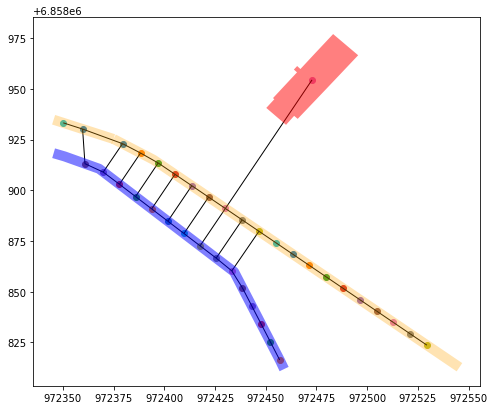

In [305]:
fig, ax = plt.subplots(figsize=(8, 8))

for p in combined_pd.centroid.tolist():
    ax.scatter(p.x,p.y)
nx.draw_networkx_edges(G=G, pos=pos,ax=ax)
sg_roads.plot(linewidth=10.0, edgecolor='#FFA500', color='#FFA500', alpha = 0.3, ax=ax)
sg_houses.plot(color='#FF0000', alpha = 0.5, ax=ax)
#sg_houses_rem.plot(color='#FFFF00', ax=ax)
sg_water.plot(linewidth=10.0, color='#0000FF', alpha = 0.5, ax=ax)
#sg_data_rail.plot(linewidth=10.0, color='#FF00FF',alpha = 0.5, ax=ax)


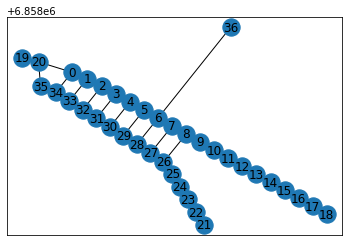

In [306]:
nx.draw_networkx(G, pos =pos)


That is it! The graphs will be saved along with their positions in pickle files in a specified folder.